# Computational Social Science Project #3 

*Group number:* 5

*Group members:* Nadia Almasalkhi, Daniel Lobo, Luyi Jian

*Semester:* Fall 2021

# 1. Libraries setup

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelBinarizer


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

sns.set_style("darkgrid")
np.random.seed(273)

# Make sure to import other libraries that will be necessary for training models!

# 2. Data Pre-Processing and Cleaning

In [2]:
# Inspections Data 2011 - 2013
chicago_inspections_2011_to_2013 = pd.read_csv("data/Chicago Inspections 2011-2013.csv", 
                                              low_memory=False)

# Inspections Data 2014
chicago_inspections_2014 = pd.read_csv("data/Chicago Inspections 2014.csv", 
                                      low_memory=False)

In [3]:
# Look at the inspections data
chicago_inspections_2011_to_2013.head()

,Inspection_ID,Inspection_Date,DBA_Name,AKA_Name,License,Facility_Type,Risk,Address,City,State,Zip,Inspection_Type,Results,Latitude,Longitude,Location,Facility_Type_Clean,criticalCount,seriousCount,minorCount,pass_flag,fail_flag,pastFail,pastCritical,pastSerious,pastMinor,timeSinceLast,firstRecord,ID,LICENSE_ID,ACCOUNT_NUMBER,LEGAL_NAME,DOING_BUSINESS_AS_NAME,ADDRESS,CITY,STATE,ZIP_CODE,WARD,PRECINCT,WARD_PRECINCT,POLICE_DISTRICT,LICENSE_CODE,LICENSE_DESCRIPTION,BUSINESS_ACTIVITY_ID,BUSINESS_ACTIVITY,LICENSE_NUMBER,APPLICATION_TYPE,LICENSE_TERM_START_DATE,LICENSE_TERM_EXPIRATION_DATE,LICENSE_STATUS,LATITUDE,LONGITUDE,minDate,maxDate,ageAtInspection,consumption_on_premises_incidental_activity,tobacco,package_goods,outdoor_patio,public_place_of_amusement,limited_business_license,childrens_services_facility_license,tavern,regulated_business_license,filling_station,caterers_liquor_license,mobile_food_license,precipIntensity,temperatureMax,windSpeed,humidity,heat_burglary,heat_garbage,heat_sanitation,criticalFound
0,269961,2013-01-31,SEVEN STAR,SEVEN STAR,30790,Grocery Store,Risk 3 (Low),3352 N BROADWAY,CHICAGO,IL,60657.0,Canvass,Pass,41.943359,-87.644999,"(41.943359344775146, -87.64499875300952)",Other,0,0,2,1,0,0,0,0,0,2.0,1,30790-20110416,2081412.0,63759.0,VIRGINIA DELA ROSA,SEVEN STAR,3352 N BROADWAY 1,CHICAGO,IL,60657.0,44.0,33.0,44-33,19.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,30790.0,RENEW,2011-04-16,2013-04-15,AAI,41.943359,-87.644999,2002-02-16,2015-04-15,10.964384,0,1,0,0,0,1,0,0,0,0,0,0,0.014587,53.496667,13.340000,0.900000,26.992376,12.768572,37.748787,0
1,507211,2011-10-18,PANERA BREAD,PANERA BREAD,1475890,Restaurant,Risk 1 (High),6059 N LINCOLN AVE,CHICAGO,IL,60659.0,Canvass,Pass,41.991919,-87.709631,"(41.99191947239194, -87.70963133440333)",Restaurant,0,0,3,1,0,0,0,0,0,2.0,1,1475890-20110416,2081695.0,207283.0,"PANERA, LLC",PANERA BREAD,6059 N LINCOLN AVE C,CHICAGO,IL,60659.0,50.0,23.0,50-23,24.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,1475890.0,RENEW,2011-04-16,2013-04-15,AAI,41.991919,-87.709631,2004-05-05,2019-04-15,7.457534,0,0,0,0,0,0,0,0,0,0,0,0,0.001907,59.046667,13.016667,0.550000,13.976557,12.895485,15.412267,0
2,507212,2011-10-18,LITTLE QUIAPO RESTAURANT,LITTLE QUIAPO RESTAURANT,1740130,Restaurant,Risk 1 (High),6259 N MCCORMICK RD,CHICAGO,IL,60659.0,Canvass,Fail,41.995632,-87.712707,"(41.99563177556418, -87.71270678169132)",Restaurant,0,2,6,0,1,0,0,0,0,2.0,1,1740130-20110216,2070145.0,3107.0,ENELITA GARCIA,LITTLE QUIAPO RESTAURANT,6259 N MCCORMICK RD,CHICAGO,IL,60659.0,50.0,25.0,50-25,17.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,1740130.0,RENEW,2011-02-16,2013-02-15,AAI,41.995632,-87.712707,2007-03-22,2017-02-15,4.578082,0,0,0,0,0,0,0,0,0,0,0,0,0.001907,59.046667,13.016667,0.550000,12.611239,8.004220,8.320330,0
3,507216,2011-10-19,SERGIO'S TAQUERIA PIZZA INC.,SERGIO'S TAQUERIA PIZZA,1447363,Restaurant,Risk 1 (High),3253 W BRYN MAWR AVE,CHICAGO,IL,60659.0,Canvass,Pass,41.982933,-87.710982,"(41.982933189164974, -87.71098225381141)",Restaurant,0,0,6,1,0,0,0,0,0,2.0,1,1447363-20110216,2071895.0,270993.0,SERGIO'S TAZUERIA PIZZA INC.,SERGIO'S TAQUERIA PIZZA INC.,3253 W BRYN MAWR AVE,CHICAGO,IL,60659.0,39.0,48.0,39-48,17.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,1447363.0,RENEW,2011-02-16,2013-02-15,AAI,41.982933,-87.710982,2003-12-31,2019-02-15,7.805479,0,0,0,0,0,0,0,0,0,0,0,0,0.002737,56.153333,10.863333,0.616667,35.906383,26.238645,38.186618,0
4,507219,2011-10-20,TARGET STORE # T-2079,TARGET,1679459,Restaurant,Risk 2 (Medium),2112 W PETERSON AVE,CHICAGO,IL,60659.0,Canvass,Fail,41.990729,-87.682979,"(41.99072921796059, -87.68297945359863)",Restaurant,0,2,6,0,1,0,0,0,0,2.0,1,1679459-20100216,2009972.0,15538.0,TARGET CORPORATION,TARGET STORE # T-2079,2112 W PETERSON AVE,CHICAGO,IL,60659.0,40.0,18.0,40-18,24.0,1006.0,Retail Food Establishment,775,Retail Sales of Perishable Foods,1679459.0,RENEW,

In [4]:
# List column names
chicago_inspections_2011_to_2013.columns

Index(['Inspection_ID', 'Inspection_Date', 'DBA_Name', 'AKA_Name', 'License',
       'Facility_Type', 'Risk', 'Address', 'City', 'State', 'Zip',
       'Inspection_Type', 'Results', 'Latitude', 'Longitude', 'Location',
       'Facility_Type_Clean', 'criticalCount', 'seriousCount', 'minorCount',
       'pass_flag', 'fail_flag', 'pastFail', 'pastCritical', 'pastSerious',
       'pastMinor', 'timeSinceLast', 'firstRecord', 'ID', 'LICENSE_ID',
       'ACCOUNT_NUMBER', 'LEGAL_NAME', 'DOING_BUSINESS_AS_NAME', 'ADDRESS',
       'CITY', 'STATE', 'ZIP_CODE', 'WARD', 'PRECINCT', 'WARD_PRECINCT',
       'POLICE_DISTRICT', 'LICENSE_CODE', 'LICENSE_DESCRIPTION',
       'BUSINESS_ACTIVITY_ID', 'BUSINESS_ACTIVITY', 'LICENSE_NUMBER',
       'APPLICATION_TYPE', 'LICENSE_TERM_START_DATE',
       'LICENSE_TERM_EXPIRATION_DATE', 'LICENSE_STATUS', 'LATITUDE',
       'LONGITUDE', 'minDate', 'maxDate', 'ageAtInspection',
       'consumption_on_premises_incidental_activity', 'tobacco',
       'package_goods',

In [5]:
# Drop column names related to geography, identification, and pass/fail flags that perfectly predict the outcome
chicago_inspections_2011_to_2013.drop(columns = ['AKA_Name', 
                                                 'License',
                                                'Address',
                                                'City',
                                                'State',
                                                'Zip',
                                                'Latitude',
                                                'Longitude',
                                                'Location',
                                                'ID',
                                                'LICENSE_ID',
                                                 'LICENSE_TERM_START_DATE',
                                                 'LICENSE_TERM_EXPIRATION_DATE',
                                                 'LICENSE_STATUS',
                                                'ACCOUNT_NUMBER',
                                                'LEGAL_NAME',
                                                'DOING_BUSINESS_AS_NAME',
                                                'ADDRESS',
                                                'CITY',
                                                'STATE',
                                                'ZIP_CODE',
                                                'WARD',
                                                'PRECINCT',
                                                'LICENSE_CODE',
                                                'BUSINESS_ACTIVITY_ID',
                                                'BUSINESS_ACTIVITY',
                                                'LICENSE_NUMBER',
                                                'LATITUDE',
                                                'LONGITUDE',
                                                'pass_flag',
                                                'fail_flag'],
                                     inplace = True)

chicago_inspections_2011_to_2013.set_index(['Inspection_ID', 'DBA_Name'], inplace = True)

In [6]:
# Convert the Inspection Date to a datetime format
chicago_inspections_2011_to_2013['Inspection_Date'] = pd.to_datetime(chicago_inspections_2011_to_2013['Inspection_Date'], infer_datetime_format=True)  

In [7]:
chicago_inspections_2011_to_2013.head()

,,Inspection_Date,Facility_Type,Risk,Inspection_Type,Results,Facility_Type_Clean,criticalCount,seriousCount,minorCount,pastFail,pastCritical,pastSerious,pastMinor,timeSinceLast,firstRecord,WARD_PRECINCT,POLICE_DISTRICT,LICENSE_DESCRIPTION,APPLICATION_TYPE,minDate,maxDate,ageAtInspection,consumption_on_premises_incidental_activity,tobacco,package_goods,outdoor_patio,public_place_of_amusement,limited_business_license,childrens_services_facility_license,tavern,regulated_business_license,filling_station,caterers_liquor_license,mobile_food_license,precipIntensity,temperatureMax,windSpeed,humidity,heat_burglary,heat_garbage,heat_sanitation,criticalFound
Inspection_ID,DBA_Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
269961,SEVEN STAR,2013-01-31,Grocery Store,Risk 3 (Low),Canvass,Pass,Other,0,0,2,0,0,0,0,2.0,1,44-33,19.0,Retail Food Establishment,RENEW,2002-02-16,2015-04-15,10.964384,0,1,0,0,0,1,0,0,0,0,0,0,0.014587,53.496667,13.340000,0.900000,26.992376,12.768572,37.748787,0
507211,PANERA BREAD,2011-10-18,Restaurant,Risk 1 (High),Canvass,Pass,Restaurant,0,0,3,0,0,0,0,2.0,1,50-23,24.0,Retail Food Establishment,RENEW,2004-05-05,2019-04-15,7.457534,0,0,0,0,0,0,0,0,0,0,0,0,0.001907,59.046667,13.016667,0.550000,13.976557,12.895485,15.412267,0
507212,LITTLE QUIAPO RESTAURANT,2011-10-18,Restaurant,Risk 1 (High),Canvass,Fail,Restaurant,0,2,6,0,0,0,0,2.0,1,50-25,17.0,Retail Food Establishment,RENEW,2007-03-22,2017-02-15,4.578082,0,0,0,0,0,0,0,0,0,0,0,0,0.001907,59.046667,13.016667,0.550000,12.611239,8.004220,8.320330,0
507216,SERGIO'S TAQUERIA PIZZA INC.,2011-10-19,Restaurant,Risk 1 (High),Canvass,Pass,Restaurant,0,0,6,0,0,0,0,2.0,1,39-48,17.0,Retail Food Establishment,RENEW,2003-12-31,2019-02-15,7.805479,0,0,0,0,0,0,0,0,0,0,0,0,0.002737,56.153333,10.863333,0.616667,35.906383,26.238645,38.186618,0
507219,TARGET STORE # T-2079,2011-10-20,Restaurant,Risk 2 (Medium),Canvass,Fail,Restaurant,0,2,6,0,0,0,0,2.0,1,40-18,24.0,Retail Food Establishment,RENEW,2006-07-07,2018-02-15,5.290411,0,0,1,0,0,1,0,0,0,0,0,0,0.009987,52.730000,16.266667,0.690000,9.530785,3.401567,2.126788,0


## Visualization

What do inspections look like over time?

<AxesSubplot:title={'center':'Inspections by Month and Year'}, xlabel='Inspection_MonthYear'>

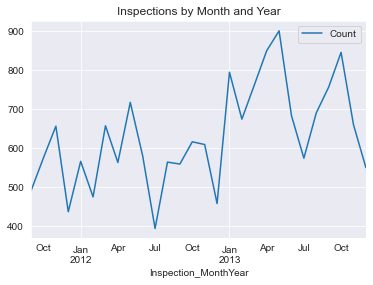

In [8]:
# Visualize Inspections Over Time
chicago_inspections_2011_to_2013['Inspection_MonthYear'] = chicago_inspections_2011_to_2013['Inspection_Date'].dt.to_period('M')
counts_by_day = chicago_inspections_2011_to_2013.groupby('Inspection_MonthYear').count().rename(columns = {'Facility_Type': 'Count'})['Count'].reset_index()
counts_by_day.set_index(["Inspection_MonthYear"], inplace = True)
counts_by_day.plot(title = "Inspections by Month and Year") 

What do the results look like? 

**Answer:** It looks like the volume of inspections vary over the year, falling into lulls for months at a time (particularly around the holidays in December and in the month of July). It also appears that there were more inspections in 2013 than in 2012.
<font color = 'blue'> The count of inspection in Jan. 2012 is over 500 and in Jan. 2013 is nearly 800, which seems to be not falling into lulls? -Luyi </font>

<font color = 'green'> The line graph plot shows that the number of inspections varies pretty dramatically over the course of the year. Overall, we see fewer inspections in 2012 compared to the first three quarters of 2013. There also appears to be a trend of inspections rising in the winter months and declining in the spring/early summer months. -Daniel </font>

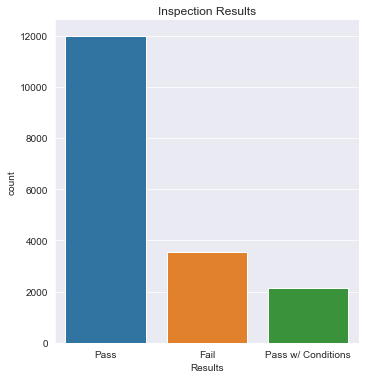

In [9]:
# Inspection Results
sns.catplot(data = chicago_inspections_2011_to_2013,
           x = "Results",
           kind = "count")

plt.title("Inspection Results")
plt.show()

What if we separate by facility type?

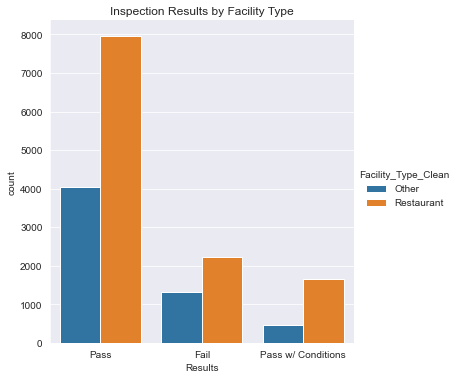

In [10]:
# Inspection Results by Facility Type (Restaurant or Not)
sns.catplot(data = chicago_inspections_2011_to_2013,
           x = "Results",
           kind = "count",
           hue = 'Facility_Type_Clean')

plt.title("Inspection Results by Facility Type")
plt.show()

## Preprocess Data

In [11]:
# Drop datetime info
chicago_inspections_2011_to_2013 = chicago_inspections_2011_to_2013.dropna().drop(['Inspection_Date',
                                      'minDate',
                                      'maxDate',
                                      'Inspection_MonthYear'],
                                      axis = 1)

In [12]:
# Set target variable. 
y = chicago_inspections_2011_to_2013['Results']
## Comment out the following code if you don't want to binarize the target variable
y = y.replace({'Pass w/ Conditions': 'Pass'})
lb_style = LabelBinarizer()
y = lb_style.fit_transform(y)
# Recode 0s and 1s so 1s are "Fail"
y = np.where(y == 1, 0 ,1)

# All other features in X
X = chicago_inspections_2011_to_2013.drop(columns = ['Results'])


In [13]:
X = pd.get_dummies(X)

In [14]:
X.head()

criticalCount  seriousCount  \
Inspection_ID DBA_Name                                                    
269961        SEVEN STAR                                0             0   
507211        PANERA BREAD                              0             0   
507212        LITTLE QUIAPO RESTAURANT                  0             2   
507216        SERGIO'S TAQUERIA PIZZA INC.              0             0   
507219        TARGET STORE # T-2079                     0             2   

                                            minorCount  pastFail  \
Inspection_ID DBA_Name                                             
269961        SEVEN STAR                             2         0   
507211        PANERA BREAD                           3         0   
507212        LITTLE QUIAPO RESTAURANT               6         0   
507216        SERGIO'S TAQUERIA PIZZA INC.           6         0   
507219        TARGET STORE # T-2079                  6         0   

                                            pastCritical  pastSerious  \
Inspection_ID DBA_Name                                                  
269961        SEVEN STAR                               0            0   
507211        PANERA BREAD                             0            0   
507212        LITTLE QUIAPO RESTAURANT                 0            0   
507216        SERGIO'S TAQUERIA PIZZA INC.             0            0   
507219        TARGET STORE # T-2079                    0            0   

                                            pastMinor  timeSinceLast  \
Inspection_ID DBA_Name                                                 
269961        SEVEN STAR                            0            2.0   
507211        PANERA BREAD                          0            2.0   
507212        LITTLE QUIAPO RESTAURANT              0            2.0   
507216        SERGIO'S TAQUERIA PIZZA INC.          0            2.0   
507219        TARGET STORE # T-2079                 0            2.0   

                                            firstRecord  POLICE_DISTRICT  \
Inspection_ID DBA_Name                                                     
269961        SEVEN STAR                              1             19.0   
507211        PANERA BREAD                            1             24.0   
507212        LITTLE QUIAPO RESTAURANT                1             17.0   
507216        SERGIO'S TAQUERIA PIZZA INC.            1             17.0   
507219        TARGET STORE # T-2079                   1             24.0   

                                            ageAtInspection  \
Inspection_ID DBA_Name                                        
269961        SEVEN STAR                          10.964384   
507211        PANERA BREAD                         7.457534   
507212        LITTLE QUIAPO RESTAURANT             4.578082   
507216        SERGIO'S TAQUERIA PIZZA INC.         7.805479   
507219        TARGET STORE # T-2079                5.290411   

                                            consumption_on_premises_incidental_activity  \
Inspection_ID DBA_Name                                                                    
269961        SEVEN STAR                                                              0   
507211        PANERA BREAD                                                            0   
507212        LITTLE QUIAPO RESTAURANT                                                0   
507216        SERGIO'S TAQUERIA PIZZA INC.                                            0   
507219        TARGET STORE # T-2079                                                   0   

                                            tobacco  package_goods  \
Inspection_ID DBA_Name                                               
269961        SEVEN STAR                          1              0   
507211        PANERA BREAD                        0              0   
507212        LITTLE QUIAPO RESTAURANT            0              0   
507216        SERGIO'S TAQUERIA PIZZA INC.        0          

It seems like we should merge `Facility_Type_1023`, because currently they appear as 4 slightly different columns:
* `Facility_Type_1023 CHILDERN'S SERVICE FACILITY`	
* `Facility_Type_1023 CHILDERN'S SERVICE S FACILITY`	
* `Facility_Type_1023 CHILDERN'S SERVICES FACILITY`	
* `Facility_Type_1023-CHILDREN'S SERVICES FACILITY`
* `Facility_Type_Children's Services Facility`

-*Nadia*

In [16]:
# To merge `Facility_Type_1023` - Luyi 

X['Facility_Type_1023 CHILDERNS SERVICE FACILITY'] = X.apply(lambda x: x["Facility_Type_1023 CHILDERN'S SERVICE FACILITY"] + x["Facility_Type_1023 CHILDERN'S SERVICE S FACILITY"] + x["Facility_Type_1023 CHILDERN'S SERVICES FACILITY"] + x["Facility_Type_1023-CHILDREN'S SERVICES FACILITY"] + x["Facility_Type_Children's Services Facility"], axis=1)

X = X.drop(columns = ["Facility_Type_1023 CHILDERN'S SERVICE FACILITY",
                      "Facility_Type_1023 CHILDERN'S SERVICE S FACILITY",
                     "Facility_Type_1023 CHILDERN'S SERVICES FACILITY",
                     "Facility_Type_1023-CHILDREN'S SERVICES FACILITY",
                     "Facility_Type_Children's Services Facility"])

In [17]:
X["Facility_Type_1023 CHILDERNS SERVICE FACILITY"] = X["Facility_Type_1023 CHILDERNS SERVICE FACILITY"].astype(int)

In [18]:
X.head()

criticalCount  seriousCount  \
Inspection_ID DBA_Name                                                    
269961        SEVEN STAR                                0             0   
507211        PANERA BREAD                              0             0   
507212        LITTLE QUIAPO RESTAURANT                  0             2   
507216        SERGIO'S TAQUERIA PIZZA INC.              0             0   
507219        TARGET STORE # T-2079                     0             2   

                                            minorCount  pastFail  \
Inspection_ID DBA_Name                                             
269961        SEVEN STAR                             2         0   
507211        PANERA BREAD                           3         0   
507212        LITTLE QUIAPO RESTAURANT               6         0   
507216        SERGIO'S TAQUERIA PIZZA INC.           6         0   
507219        TARGET STORE # T-2079                  6         0   

                                            pastCritical  pastSerious  \
Inspection_ID DBA_Name                                                  
269961        SEVEN STAR                               0            0   
507211        PANERA BREAD                             0            0   
507212        LITTLE QUIAPO RESTAURANT                 0            0   
507216        SERGIO'S TAQUERIA PIZZA INC.             0            0   
507219        TARGET STORE # T-2079                    0            0   

                                            pastMinor  timeSinceLast  \
Inspection_ID DBA_Name                                                 
269961        SEVEN STAR                            0            2.0   
507211        PANERA BREAD                          0            2.0   
507212        LITTLE QUIAPO RESTAURANT              0            2.0   
507216        SERGIO'S TAQUERIA PIZZA INC.          0            2.0   
507219        TARGET STORE # T-2079                 0            2.0   

                                            firstRecord  POLICE_DISTRICT  \
Inspection_ID DBA_Name                                                     
269961        SEVEN STAR                              1             19.0   
507211        PANERA BREAD                            1             24.0   
507212        LITTLE QUIAPO RESTAURANT                1             17.0   
507216        SERGIO'S TAQUERIA PIZZA INC.            1             17.0   
507219        TARGET STORE # T-2079                   1             24.0   

                                            ageAtInspection  \
Inspection_ID DBA_Name                                        
269961        SEVEN STAR                          10.964384   
507211        PANERA BREAD                         7.457534   
507212        LITTLE QUIAPO RESTAURANT             4.578082   
507216        SERGIO'S TAQUERIA PIZZA INC.         7.805479   
507219        TARGET STORE # T-2079                5.290411   

                                            consumption_on_premises_incidental_activity  \
Inspection_ID DBA_Name                                                                    
269961        SEVEN STAR                                                              0   
507211        PANERA BREAD                                                            0   
507212        LITTLE QUIAPO RESTAURANT                                                0   
507216        SERGIO'S TAQUERIA PIZZA INC.                                            0   
507219        TARGET STORE # T-2079                                                   0   

                                            tobacco  package_goods  \
Inspection_ID DBA_Name                                               
269961        SEVEN STAR                          1              0   
507211        PANERA BREAD                        0              0   
507212        LITTLE QUIAPO RESTAURANT            0              0   
507216        SERGIO'S TAQUERIA PIZZA INC.        0          

# 3. Fit Models

## 3.1 Data Splitting

In [19]:

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .80, test_size=0.20,
                                                   stratify=y)

X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, train_size = .75, test_size = .25, 
                                                           stratify = y_train)

## 3.2 Fit Models

### 3.2.1 Model 1 - Support Vector Machine

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem:

SVM: The maximal margin classifier, the support vector classifier, and the support vector machine are often referred as “support vector machines”. Specifically, Maximal Margin Classifier (AKA Hard Margin)uses a hyperplane that separates the training observations perfectly according to their class labels; while Support Vector Classifier / Soft Margin Classifier use the same logic of hyperplane but allow misclassifying a few training observations to get better predictions in testing observations (namely, to avoid overfitting in training set). 

In other words, Hard Margin finds the hyperplane and margin that correctly classifies all points. It is sensitive to single observations/outliers, has the risk of overfitting, and will fail entirely if the data are not linearly separable. But Soft Margin, by allowing some points to “violate” the margin, trades off some bias for better variance (avoiding overfitting).

For this problem, because there are so many features and we don't know if the data are linearly separable, it's better to use SVM to allow some fexibility in prediction. 


(FROM THE INSTRUCTION) Be sure to do the following:

1. Import the appropriate library from sklearn
2. Set up a hyperparameter grid (check out our previous labs to see how to do this)
3. Find the best hyperparameters, and then fit your model (using train/validation splits or cross-validation)

In [20]:
# create a model
svm = SVC()

# fit the model
svm_model = svm.fit(X_train, y_train.ravel())

y_pred = svm_model.predict(X_validate)

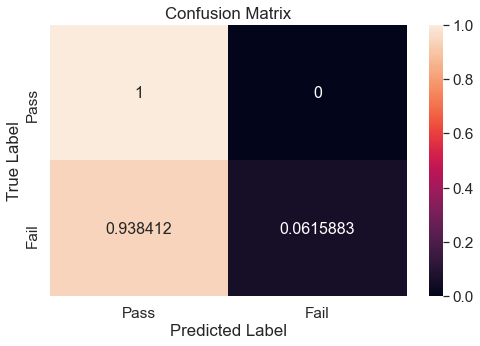

In [21]:
# look at the confusion matrix of SVM 
cf_matrix = confusion_matrix(y_validate, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Pass", 1: "Fail"})
df_cm.index = ["Pass", "Fail"]
plt.figure(figsize = (8,5))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

From the confusion matrix, the SVM predicts well for facilities that passed the inspection (1.0), but predicts poorly for those failed the inspection (0.06), due to the imbalance of data structure where very few facilities failed inspection. Next we will search for optimal hyperparameters and see if the SVM with tuned parameters will perform better. 

In [22]:
# use GridSearchCV to search for optimal hyperparameters  (Hyperparameter Tuning)

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')
from sklearn.metrics import accuracy_score

param_grid = {'C': [0.1, 1, 10, 100],   # C: the regularization parameter, C, of the error term.
              'gamma': [1, 0.1, 0.01, 0.001],  # gamma: the kernel coefficient for ‘rbf’, ‘poly’, and ‘sigmoid’. If gamma is ‘auto’, then 1/n_features will be used instead.
              'kernel': ['rbf']}  # kernel: specifies the kernel type to be used in the algorithm. It can be ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’, or a callable. The default value is ‘rbf’.

# Grid search (for hyperparameter)
svm_grid = GridSearchCV(svm_model, param_grid, cv=3)

# Fit model on training data
svm_grid.fit(X_train, y_train)

# Get best model by mean test score
best_index = np.argmax(svm_grid.cv_results_["mean_test_score"])

# Get best predictions by predicting on validation set
best_svm_pred = svm_grid.best_estimator_.predict(X_validate)

# Print the best parameters, CV r2, validation r2, and validation RMSE
print(svm_grid.cv_results_["params"][best_index])
print('Validation Accuracy', accuracy_score(best_svm_pred, y_validate))

KeyboardInterrupt: 

In [ ]:
# Use the tuned SVM model to predict in the validation set
svm_pred = svm_grid.best_estimator_.predict(X_validate)
print('validation CV R^2:', max(svm_grid.cv_results_["mean_test_score"]))
print('validation R^2:', svm_grid.score(X_validate, y_validate))
print('validation RMSE', rmse(svm_pred, y_validate))

### 3.2.2 Model 2 - Decision Tree Classifier

Decision Trees are are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation. 

Some advatanges of Decision Trees are the following: They are simple to understand, to interpret, and to visualize. They require little data preparation and are able to handle both numerical and categorical data. They are considered white box models instead of black box models, meaning that if a given situation is observable in a model, the explanation for the condition is easily explained by boolean logic. Black box models on the other hand, like neural networks, are more difficult to interpret. Decision trees are able to handle multi-output problems. It is possible to validate a Decision Tree model using statistical tests, making it possible to account for the reliability of the model. Lastly, Decision Trees perform well even if its assumptions are somewhat violated by the true model from which the data were generated.

Some disadvantages of Decision Trees are the following: Overly complex Decision Trees can overfit to the data. Mechanisms such as pruning, setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem. Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This problem is mitigated by using decision trees within an ensemble. Becuase Decision Tree predictions are piece-wise constant approximations and not continuous, they are not good at extrapolation. Practical decision-tree learning algorithms are based on heuristic algorithms such as the greedy algorithm where locally optimal decisions are made at each node. Such algorithms cannot guarantee to return the globally optimal decision tree. This can be mitigated by training multiple trees in an ensemble learner, where the features and samples are randomly sampled with replacement.

The Decision Tree Classifier is a plausible choice for this problem because our data is non-linear and our outcome variable is not continuous. 

In [23]:
# Initialize a Decision Tree Classifier
dt_classifier = tree.DecisionTreeClassifier(criterion='gini',  # or 'entropy' for information gain
                       splitter='best',  # or 'random' for random best split
                       max_depth=None,  # how deep tree nodes can go
                       min_samples_split=2,  # samples needed to split node
                       min_samples_leaf=1,  # samples needed for a leaf
                       min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                       max_features=None,  # number of features to look for when splitting
                       max_leaf_nodes=None,  # max nodes
                       min_impurity_decrease=1e-07, #early stopping
                       random_state = 10) #random seed

In [24]:
# Use cross validation to train the model on our data 
scores = cross_val_score(dt_classifier, X, y, cv=5)

In [25]:
scores

array([0.90140385, 0.89581973, 0.906597  , 0.90953625, 0.906597  ])

In [26]:
# Take the mean score from the results of cross validation
scores.mean()

0.9039907639547724

A unique aspect of tree-based methods is feature importance. One way to calculate feature importance is to see how much information each new feature adds. If a feature does not add any or very little information to a prediction, it may be possible to safely drop it.

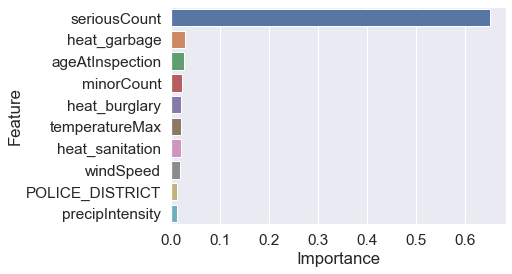

In [27]:
dt_classifier.fit(X_train, y_train)
feat_importances = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(dt_classifier.feature_importances_))], axis = 1)
feat_importances.columns = ["Feature", "Importance"]
sns.barplot(x = "Importance", y = "Feature", data = feat_importances.nlargest(10, 'Importance'))
plt.show()

#### Interpretation: 
We see that seriousCount is by far the most important feature in the model, far more important than the the next 9 most important features combined. 

In [28]:
# Create a list with the top 10 features for the Decision Tree Classifier
dt_feature_df = feat_importances.nlargest(10, 'Importance')
dt_feature_list = list(dt_feature_df["Feature"])
dt_feature_list

['seriousCount',
 'heat_garbage',
 'ageAtInspection',
 'minorCount',
 'heat_burglary',
 'temperatureMax',
 'heat_sanitation',
 'windSpeed',
 'POLICE_DISTRICT',
 'precipIntensity']

In [29]:
# Reduce dataset X to include only the select 10 features
reduced_X = X[dt_feature_list]
reduced_X.head()

,,seriousCount,heat_garbage,ageAtInspection,minorCount,heat_burglary,temperatureMax,heat_sanitation,windSpeed,POLICE_DISTRICT,precipIntensity
Inspection_ID,DBA_Name,,,,,,,,,,
269961,SEVEN STAR,0,12.768572,10.964384,2,26.992376,53.496667,37.748787,13.340000,19.0,0.014587
507211,PANERA BREAD,0,12.895485,7.457534,3,13.976557,59.046667,15.412267,13.016667,24.0,0.001907
507212,LITTLE QUIAPO RESTAURANT,2,8.004220,4.578082,6,12.611239,59.046667,8.320330,13.016667,17.0,0.001907
507216,SERGIO'S TAQUERIA PIZZA INC.,0,26.238645,7.805479,6,35.906383,56.153333,38.186618,10.863333,17.0,0.002737
507219,TARGET STORE # T-2079,2,3.401567,5.290411,6,9.530785,52.730000,2.126788,16.266667,24.0,0.009987


In [30]:
# split the reduced data into training and test set
reduced_X_train, reduced_X_test, reduced_y_train, reduced_y_test = train_test_split(reduced_X, y, train_size=0.80, test_size=0.20)
#split reduced training data into training and validation data
reduced_X_train, reduced_X_validate, reduced_y_train, reduced_y_validate = train_test_split(reduced_X_train, reduced_y_train, train_size=0.75, test_size=0.25)

In [31]:
# Re-fit the Decision Tree Classifier on reduced data
dt_classifier.fit(reduced_X_train, reduced_y_train)

DecisionTreeClassifier(min_impurity_decrease=1e-07, random_state=10)

In [32]:
# Use cross validation to train the model on our reduced data 
scores = cross_val_score(dt_classifier, reduced_X, y, cv=5)

In [33]:
scores

array([0.8935684 , 0.89320705, 0.89483997, 0.89549314, 0.89647289])

In [34]:
scores.mean()

0.8947162920707383

#### Interpretation: 
We see that dropping all but the 10 most important features of the model slightly reduces the accuracy of our Decision Tree Classifier's predictions from 91 percent to 89 percent. 

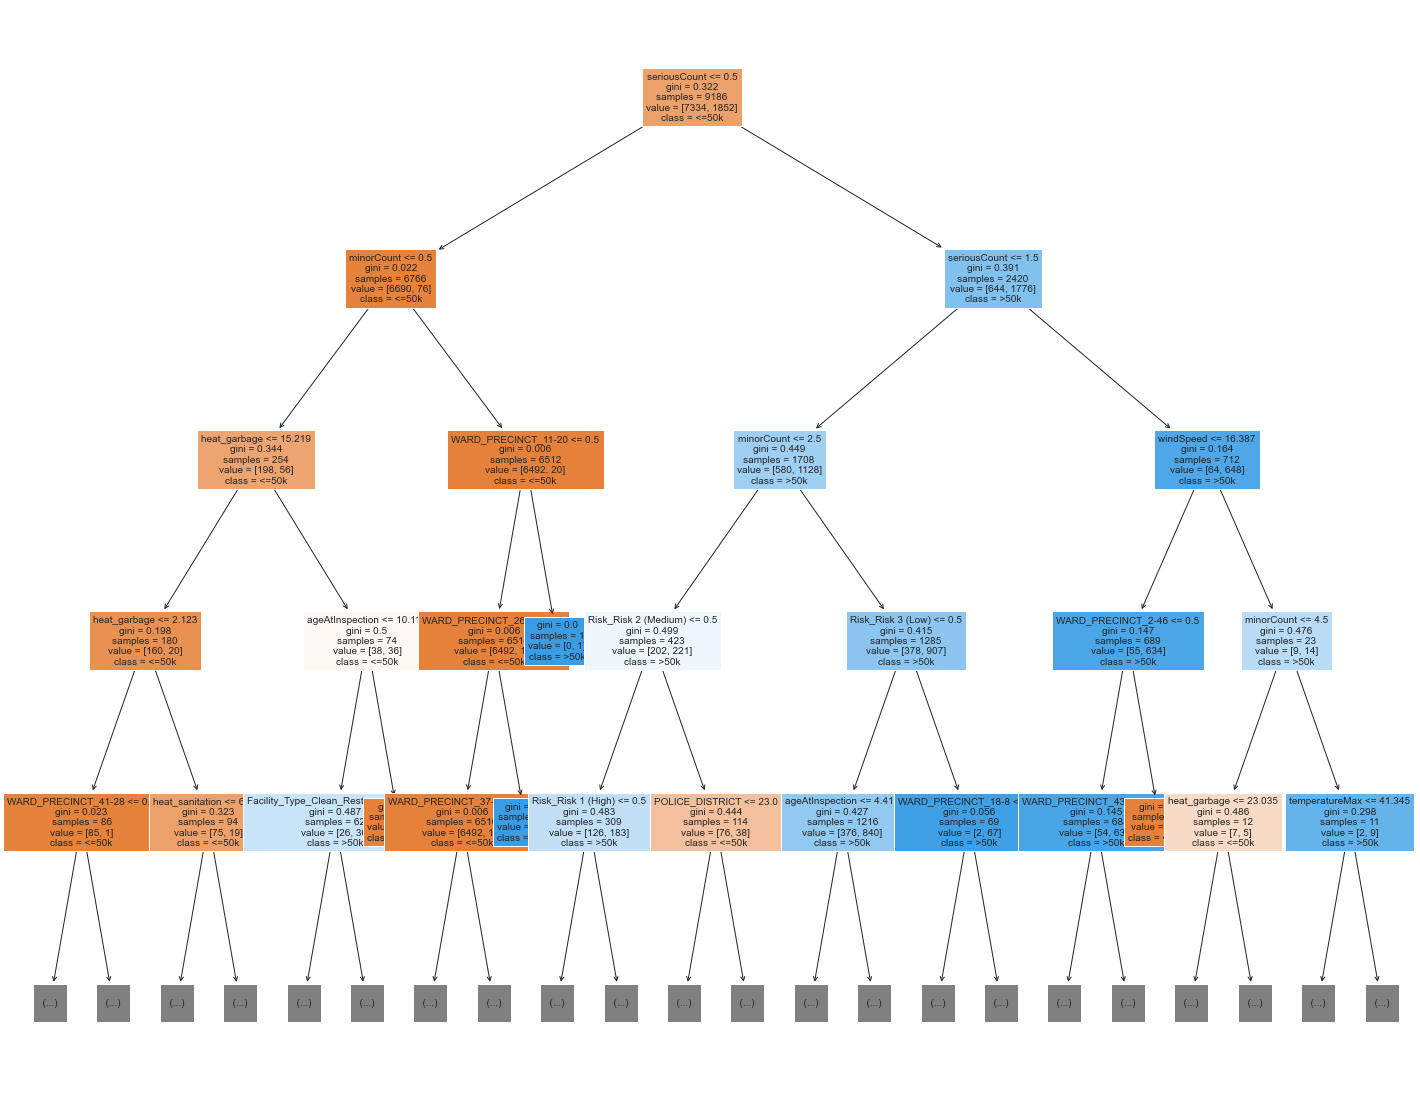

In [35]:
# To visualize our Decision Tree Classifier model on the original data set
dt_classifier.fit(X_train, y_train)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt_classifier, 
                   feature_names=X.columns,  
                   class_names=["<=50k", ">50k"],
                   filled=True,
                  fontsize = 10,
                  max_depth = 4)

Now we can visualize the model predictions on the validation set using a Confusion Matrix. 

In [36]:
y_pred = dt_classifier.predict(X_validate)

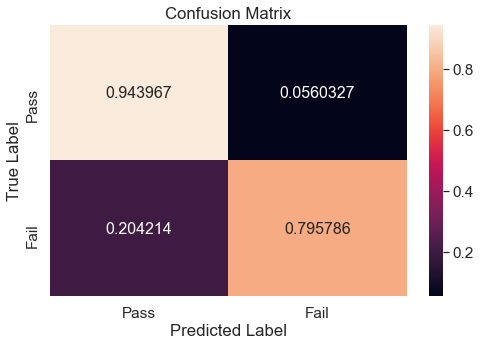

In [37]:
cf_matrix = confusion_matrix(y_validate, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Pass", 1: "Fail"})
df_cm.index = ["Pass", "Fail"]
plt.figure(figsize = (8,5))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Interpretation: 
We see that our Decision Tree Classifier is a pretty strong model. It correctly predicts a passing inspection 94 percent of the time and correctly predicts a failing inspection 80 percent of the time. 

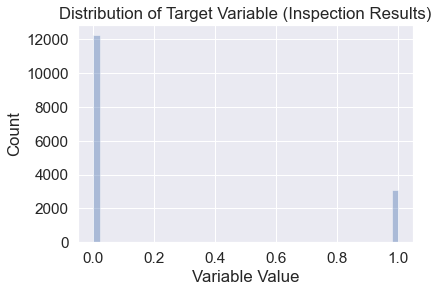

In [38]:
ax = sns.distplot(y, kde = False)
ax.set_title("Distribution of Target Variable (Inspection Results)")
ax.set(xlabel='Variable Value', ylabel='Count')
plt.show()

#### Interpretation: 
By plotting our target variable, we can see that a class imbalance between passing inspections (coded as 0) and failing inspections (coded as 1) is likely driving the poorer predictions of failing inspections from our Decision Tree Classifier model. 

<font color = 'green'> Is hyperparameter tuning applicable to Decision trees since it's a non-parametric model? </font>

### Model 3: Random Forest

In [39]:
# Inspect the shape of the y_train array
y_train.shape

(9186, 1)

`y_train` is irregularly shaped and will thus need to use `.ravel()` in order to work well

In [40]:
# Initialize the Random Forest classifier, allowing it run relatively unrestricted.

rf_classifier = RandomForestClassifier(criterion='gini',  # or 'entropy' for information gain
                       max_depth=None,  # how deep tree nodes can go
                       min_samples_split=2,  # samples needed to split node
                       min_samples_leaf=1,  # samples needed for a leaf
                       min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                       max_features=None,  # number of features to look for when splitting
                       max_leaf_nodes=None,  # max nodes
                       min_impurity_decrease=1e-07, #early stopping
                       random_state = 10) #random seed

In [42]:
# Fit this model to the training data

rf_model = rf_classifier.fit(X_train, y_train.ravel())

In [43]:
# Now let's evaluate the accuracy of the rt_classifier on the training set

y_train_pred = rf_model.predict(X_train)

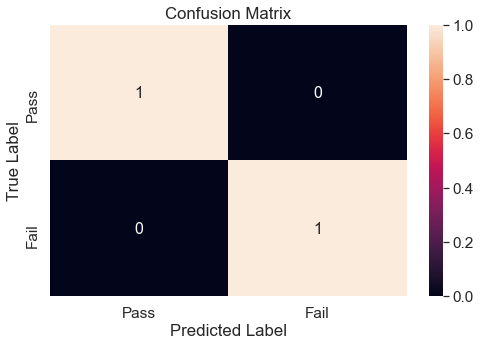

In [44]:
# Let's display the accuracy of the RF model on the training set
rf_cf_matrix = confusion_matrix(y_train, y_train_pred, normalize = "true")

rf_cm = pd.DataFrame(rf_cf_matrix, range(2),
                  range(2))

rf_cm = rf_cm.rename(index=str, columns={0: "Pass", 1: "Fail"})
rf_cm.index = ["Pass", "Fail"]
plt.figure(figsize = (8,5))
sns.set(font_scale=1.4) #for label size
sns.heatmap(rf_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

The Random Forests Model has 100% accuracy on the training set, which makes sense because we allowed it to go down to leaves of *n* = 1. The real test now will be to see how it performs on the validation set. If it performs poorly on the validation set, then that is a sign of the model overfitting the training data, and we would need to go back and restrict the overfitting of the rf_classifier by limiting the maximum depth, raising the bar for the minimum impurity decrease, or other changes to the hyperparameters.

Another way that we might restrict overfitting of the RF model to the training data would be to reduce the features considered. We will not yet implement this step, but let's just take a look at what the top features would be if we were to exclude the features that do not contribute much to the model.

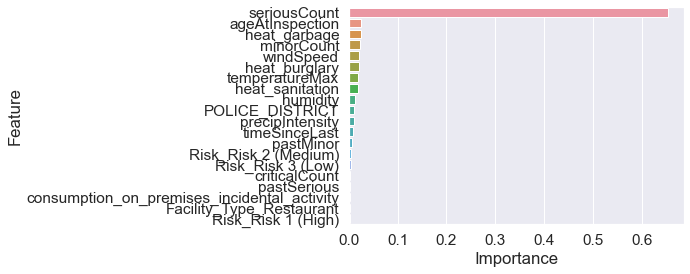

In [45]:
# Let's look also to what factors are most important.
feat_importances = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(rf_model.feature_importances_))], axis = 1)
feat_importances.columns = ["Feature", "Importance"]
sns.barplot(x = "Importance", y = "Feature", data = feat_importances.nlargest(20, 'Importance'))
plt.show()

It looks like only the top fifteen contribute much at all. If the model were to be reduced due to poor performance on the validation set, then perhaps only the first 15 features listed in this plot should be included.

<font color = 'green'> Are we supposed to be including `seriousCount` in our features? Seems like it's way too closely associated and it might be as if we're including `y` itself. </font>

## 3.3  Validation Metrics

**Hint**: Try writing a for loop to use [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) to check for accuracy, precision, recall and f1 across all of your models.

### 3.3.1 Model 1 Support Vector Machine Validation Metrics

### 3.3.2 Model 2 - Decision Tree Classifier Validation Metrics

### Accuracy
A measure of the number of correction predictions regardless of direction, divided by the total number observations. Accuracy can be expressed as:

$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

In [46]:
range(len(y_pred))

range(0, 3062)

In [47]:
TP = 0
FP = 0
TN = 0
FN = 0

for i in range(len(y_pred)): 
    if y_validate[i]==y_pred[i]==1:
       TP += 1
    if y_pred[i]==1 and y_validate[i]!=y_pred[i]:
       FP += 1
    if y_validate[i]==y_pred[i]==0:
       TN += 1
    if y_pred[i]==0 and y_pred[i]!=y_validate[i]:
       FN += 1

In [48]:
accuracy = (TP + TN)/(TP + TN + FP + FN)
print("Accuracy is", accuracy)

Accuracy is 0.9141084258654474


### Precision
Precision is a measure of how well calibrated predictions are. Specifically, it tells us of the predictions in the positive class ("failing inspection" in this case) we made, how many were correct. The formula for precision is:

$$
Precision = \frac{TP}{TP + FP}
$$

In [49]:
precision = TP/(TP + FP)
print("Precision is", precision)

Precision is 0.7818471337579618


### Recall
Recall is a measure that tells us, of all of the positive class members in the ground truth labels, how many did we successfully predict as positive? Recall is defined as:

$$
Recall = \frac{TP}{TP + FN}
$$

In [50]:
recall = TP/(TP + FN)
print("Recall is", recall)

Recall is 0.7957860615883307


### F1 Score
The F1 Score is defined as:

$$
F1 = 2 * \frac{precision * recall}{precision + recall}
$$


In [51]:
f1 = 2 * (precision * recall)/(precision + recall)
print("F1 Score is", f1)

F1 Score is 0.7887550200803213


#### Interpretation: 
In our case of predicting whether a Chicago business passes or fails a food inspection, where a true positive (TP) is correctly precicting that a business fails inspection and a false positive (FP) is incorrectly predicting that a business fails inspection, FPs and false negatives (FN) are high stakes errors. We don't want to distrupt the operations of a business that passes inspection with a FP because that would be unfair to business owners and potentially detrimental to the community. We don't want to allow business that fails inspection to continue serving food to customers with a FN because that could be harmful to the health of the community. 

Thus, we would want to prioritize the accuracy measure in this case. Precision does not tell us anything about FNs, or incorrectly predicting that a business passes inspection, which is a critical blindpsot. Recall tells us nothing about FPs, or incorrectly predicting that a business fails inspection, which is perhaps the most urgent data point. 

### Model 3: Random Forests

In this section, accuracy, precision, recall, F1 score, and cross_val_score will be determined for the Random Forests classifier on the validation set.

In [53]:
# Create the predictions for the validation set.

y_validate_pred = rf_model.predict(X_validate)

### Accuracy
A measure of the number of correction predictions regardless of direction, divided by the total number observations. Accuracy can be expressed as:

$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

In [54]:
TP = 0
FP = 0
TN = 0
FN = 0

for i in range(len(y_validate_pred)): 
    if y_validate[i]==y_validate_pred[i]==1:
       TP += 1
    if y_validate_pred[i]==1 and y_validate[i]!=y_validate_pred[i]:
       FP += 1
    if y_validate[i]==y_validate_pred[i]==0:
       TN += 1
    if y_validate_pred[i]==0 and y_validate_pred[i]!=y_validate[i]:
       FN += 1

accuracy = (TP + TN)/(TP + TN + FP + FN)
print("Accuracy of the Random Forests model is", accuracy)

Accuracy of the Random Forests model is 0.9278249510124101


Random Forest's accuracy (=0.927) is a slight improvement over the Decision Tree classifier's accuracy (=0.914).

### Precision
Precision is a measure of how well calibrated predictions are. Specifically, it tells us of the predictions in the positive class ("failing inspection" in this case) we made, how many were correct. The formula for precision is:

$$
Precision = \frac{TP}{TP + FP}
$$

In [55]:
precision = TP/(TP + FP)
print("Precision of the Random Forests mdoel is", precision)

Precision of the Random Forests mdoel is 0.771978021978022


The Decision Tree classifier's precision (=0.781) is slightly better than Random Forests precision (=0.771).

### Recall
Recall is a measure that tells us, of all of the positive class members in the ground truth labels, how many did we successfully predict as positive? Recall is defined as:

$$
Recall = \frac{TP}{TP + FN}
$$

In [56]:
recall = TP/(TP+FN)
print("Recall of the Random Forests mdoel is", recall)

Recall of the Random Forests mdoel is 0.9108589951377634


The Random Forests model performs *significantly* better (recall=0.910) than the Decision Tree model (recall=0.795) in this measure.

### F1 Score
The F1 Score is defined as:

$$
F1 = 2 * \frac{precision * recall}{precision + recall}
$$


In [57]:
f1 = 2 * (precision * recall)/(precision + recall)
print("F1 Score for Random Forests is", f1)

F1 Score for Random Forests is 0.8356877323420075


The Random Forests f1 score (=0.835) is moderately better than that of the Decision Tree model (=0.788).

### Cross-Validation Score

In [60]:
scores = cross_val_score(rf_model, X_validate, y_validate, cv=5)
print(scores.mean())

0.9196611542931474


In [61]:
scores = cross_val_score(rf_model, X, y.ravel(), cv=5)
print(scores.mean())

0.9229312246012489


The mean cross validation scores for the Random Forests model, both when run on the validation set alone (mean cross val score = 0.919) and on the full set (mean cross val score = 0.922), are higher than the full-set mean cross_val_score of the Decision Tree model (=0.905) and the reduced Decision Tree model (=0.892).

# 4.  Policy Simulation

## 4.1  Interpretable Machine Learning

**Hint**: Use tools like feature importance plots and coefficient plots

### 4.1.2 Model 2 - Decision Tree Classifier Feature Importance Plot

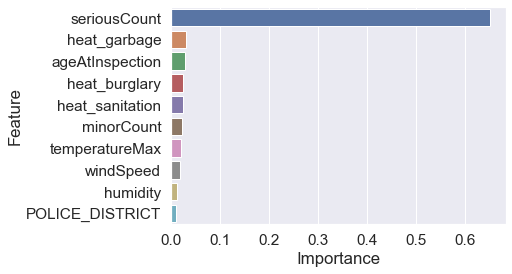

In [46]:
# Replicating Feature Importance Plot from 3.2.2 above
dt_classifier.fit(X_train, y_train)
feat_importances = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(dt_classifier.feature_importances_))], axis = 1)
feat_importances.columns = ["Feature", "Importance"]
sns.barplot(x = "Importance", y = "Feature", data = feat_importances.nlargest(10, 'Importance'))
plt.show()

#### Interpretation: 
We see that seriousCount is by far the most important feature in the model, far more important than the the next 9 most important features combined. One feature that I wish we could incorporate into the model is which inspector from the Chicago Department of Public Health’s Food Protection Program completed past inpections. Although the inspections are done using a standardized procedure, I wonder if there are were inspectors that were systematically harsher or more lenient and how that might bias the results and subsequent predictions. 

## 4.2  Prioritize Audits

**Hint**: Look up the [`.predict()`](https://www.kite.com/python/docs/sklearn.linear_model.SGDRegressor.predict), [`.predict_proba()`](https://www.kite.com/python/docs/sklearn.linear_model.LogisticRegression.predict_proba), and [`.sample()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html) methods. Then: 
1. Choose one of your models (or train a new simplified model or ensemble!) to predict outcomes and probabilities. 
2. Order your audits by their probability of detecting a "Fail" score
3. Plot your distribution of pass/fail among the first 1000 observations in the dataset
4. Simulate random audits on the full chicago_2011_to_2013.csv dataset by picking 1000 observations at random

In [54]:
# Trying to figure out how to select the 1000 riskiest establishments
X['Risk_Risk 1 (High)'].sum()

11294

In [55]:
chicago_inspections_2011_to_2013['seriousCount'].unique()

array([0, 2, 1, 3, 4, 5], dtype=int64)

In [60]:
# We could try to taking a random sample of the establishments with the highest risk of 1 who also have a serious count >1? 
chicago_inspections_2011_to_2013['seriousCount'].value_counts()

0    11296
1     2828
2      950
3      199
4       36
5        2
Name: seriousCount, dtype: int64

In [66]:
X[('Risk_Risk 1 (High)'== 1) & ('seriousCount'>1)].count()

TypeError: '>' not supported between instances of 'str' and 'int'

In [68]:
# Do we need to change one of the dtypes to be able to run the above code?
X.dtypes['Risk_Risk 1 (High)']

dtype('uint8')

In [69]:
X.dtypes['seriousCount']

dtype('int64')

## 4.3  Predict on Data with Unseen Labels

In [ ]:
# Fill in the code below with the X data you used for training
X_test = chicago_inspections_2014[chicago_inspections_2014.columns & ....columns]

# 5. Discussion Questions

### 5.1 Why do we need metrics beyond accuracy when us- ing machine learning in the social sciences and public policy?

### 5.2 Imagine that establishments learned about the algo- rithm being used to determine who gets audited and they started adjusting their behavior (and changing certain key features about themselves that were im- portant for the prediction) to avoid detection. How could policymakers address this interplay between al- gorithmic decisionmaking and real world behavior?